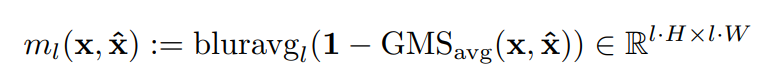

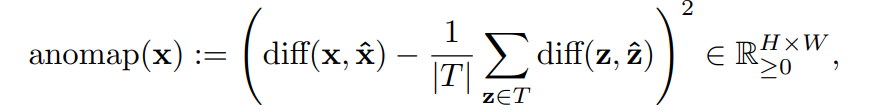

In [45]:
import torch
import torch.nn.functional as F
import math
from msgms import MSGMSLoss


def create_gaussian_kernel(kernel_size, sigma):
    """Create a Gaussian kernel."""
    gauss = torch.tensor([math.exp(-x**2 / (2 * sigma**2)) for x in range(-kernel_size//2 + 1, kernel_size//2 + 1)])
    gauss = gauss / gauss.sum()
    gauss = gauss.view(1, -1) * gauss.view(-1, 1)
    return gauss.view(1, 1, kernel_size, kernel_size)

def apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size=7, gauss_sigma=2):
    # Original spatial dimensions
    original_size = input_tensor.shape[-2:]

    # Create a uniform averaging kernel, adjusting for channel dimension
    channels = input_tensor.size(1)
    avg_kernel = torch.ones(channels, 1, scale_factor, scale_factor) / (scale_factor**2)
    avg_kernel = avg_kernel.to(input_tensor.device)

    # Apply convolution with stride equal to scale factor (for downsampling)
    downsampled_tensor = F.conv2d(input_tensor, avg_kernel, stride=scale_factor, padding=0, groups=channels)

    # Create Gaussian kernel
    gauss_kernel = create_gaussian_kernel(gauss_kernel_size, gauss_sigma).to(input_tensor.device)
    gauss_kernel = gauss_kernel.repeat(channels, 1, 1, 1)

    # Apply Gaussian blur
    smoothed_tensor = F.conv2d(downsampled_tensor, gauss_kernel, padding=gauss_kernel_size // 2, groups=channels)

    # Resize to original dimensions using bilinear interpolation
    resized_tensor = F.interpolate(smoothed_tensor, size=original_size, mode='bilinear', align_corners=False)

    return resized_tensor

def avg_multiscale(input_tensor, scale_factors=[1/2,1/4], gauss_kernel_size=7, gauss_sigma=2):
    smoothed_tensors = []
    for scale_factor in scale_factors:
        smoothed_tensors.append(apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size, gauss_sigma))
    stacked_tensor = torch.stack(smoothed_tensors, dim=0)
    diff = torch.mean(stacked_tensor, dim=0)   
    return diff

# Example usage
input_tensor = torch.randn(5, 1, 20, 20)  # Batch size of 5, 1 channel, 20x20 dimensions
final = avg_multiscale(input_tensor, scale_factors=[2, 4], gauss_kernel_size=7, gauss_sigma=2)
print(final.shape)  # Expected shape: (5, 1, 20, 20)


torch.Size([5, 1, 20, 20])


In [46]:
msgms=MSGMSLoss()
loss, map =msgms(torch.randn(20,3, 20,20),torch.randn(20,3, 20,20))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=7, gauss_sigma=2)

torch.Size([3, 256, 256])

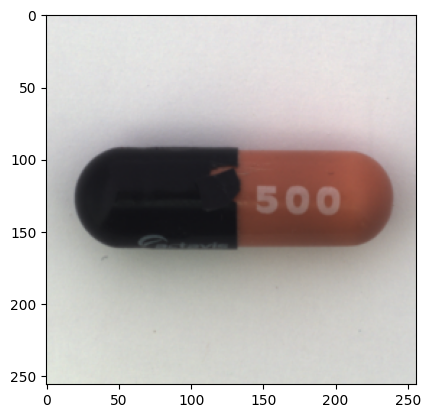

In [61]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

image = Image.open('/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/capsule/test/crack/015.png')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image_tensor = transform(image)
plt.imshow(image_tensor.permute(1, 2, 0))
image_tensor.shape


In [62]:
image_tensor.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

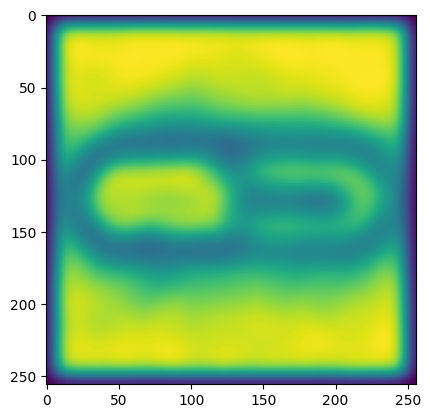

In [72]:
msgms=MSGMSLoss()
loss, map =msgms(image_tensor.unsqueeze(0),torch.randn(1,3, 256,256))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=7, gauss_sigma=2)
diff_squared = diff**2
plt.imshow(diff_squared.squeeze(0).permute(1, 2, 0))
